# EDA
## House Prices - Advanced Regression Techniques
### Objective: Predict House prices.

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview
    

## Part 1: Analyzing data

In [2]:
import math
import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
import lightgbm as lgb
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import gc

In [3]:
result_list = []

In [4]:
# Load data
test = pd.read_csv("data/test.csv", index_col=0)
train = pd.read_csv("data/train.csv", index_col=0)

In [5]:
test.shape, train.shape

((1459, 79), (1460, 80))

In [6]:
# Are there duplicates?
print(train[train.duplicated() == True].sum().sum())
print(test[test.duplicated() == True].sum().sum())

0.0
0.0


In [7]:
test.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal
2919,60,RL,74.0,9627,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,11,2006,WD,Normal


In [8]:
train.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [9]:
diff = set(train.columns) - set(test.columns)
diff

{'SalePrice'}

In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,59.00,69.0,80.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0


**Missing Values**

In [11]:
# Are there missing values?
missing_values = train.columns[train.isnull().sum() > 0].tolist()
print(train[missing_values].isnull().sum())

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


**Numerical and Categorical variables**

Recap of variables usage:

**numerical_columns**: All numerical columns including Target "SalePrice"

**categorical_columns**: All categorical columns.

**target_column** SalePrice

**train_num_columns**: Numerical columns - target

**y**: Target Data

**selected_features**: numerical + categorical - target

In [12]:
numerical_columns = train.select_dtypes(include=['int', 'float']).columns
X_num = train[numerical_columns]

categorical_columns = train.select_dtypes(include=['object']).columns
X_cat = train[categorical_columns]

target_column = 'SalePrice'
train_num_columns = numerical_columns.drop(target_column)

y = train[target_column]
selected_features = train_num_columns.append(categorical_columns)

print('Numerical columns:', train_num_columns.size)
print('Categorical columns:', categorical_columns.size)
print('Total:', selected_features.size)
print('Target:', target_column)

Numerical columns: 36
Categorical columns: 43
Total: 79
Target: SalePrice


**Plot Distribution of Numerical Columns**

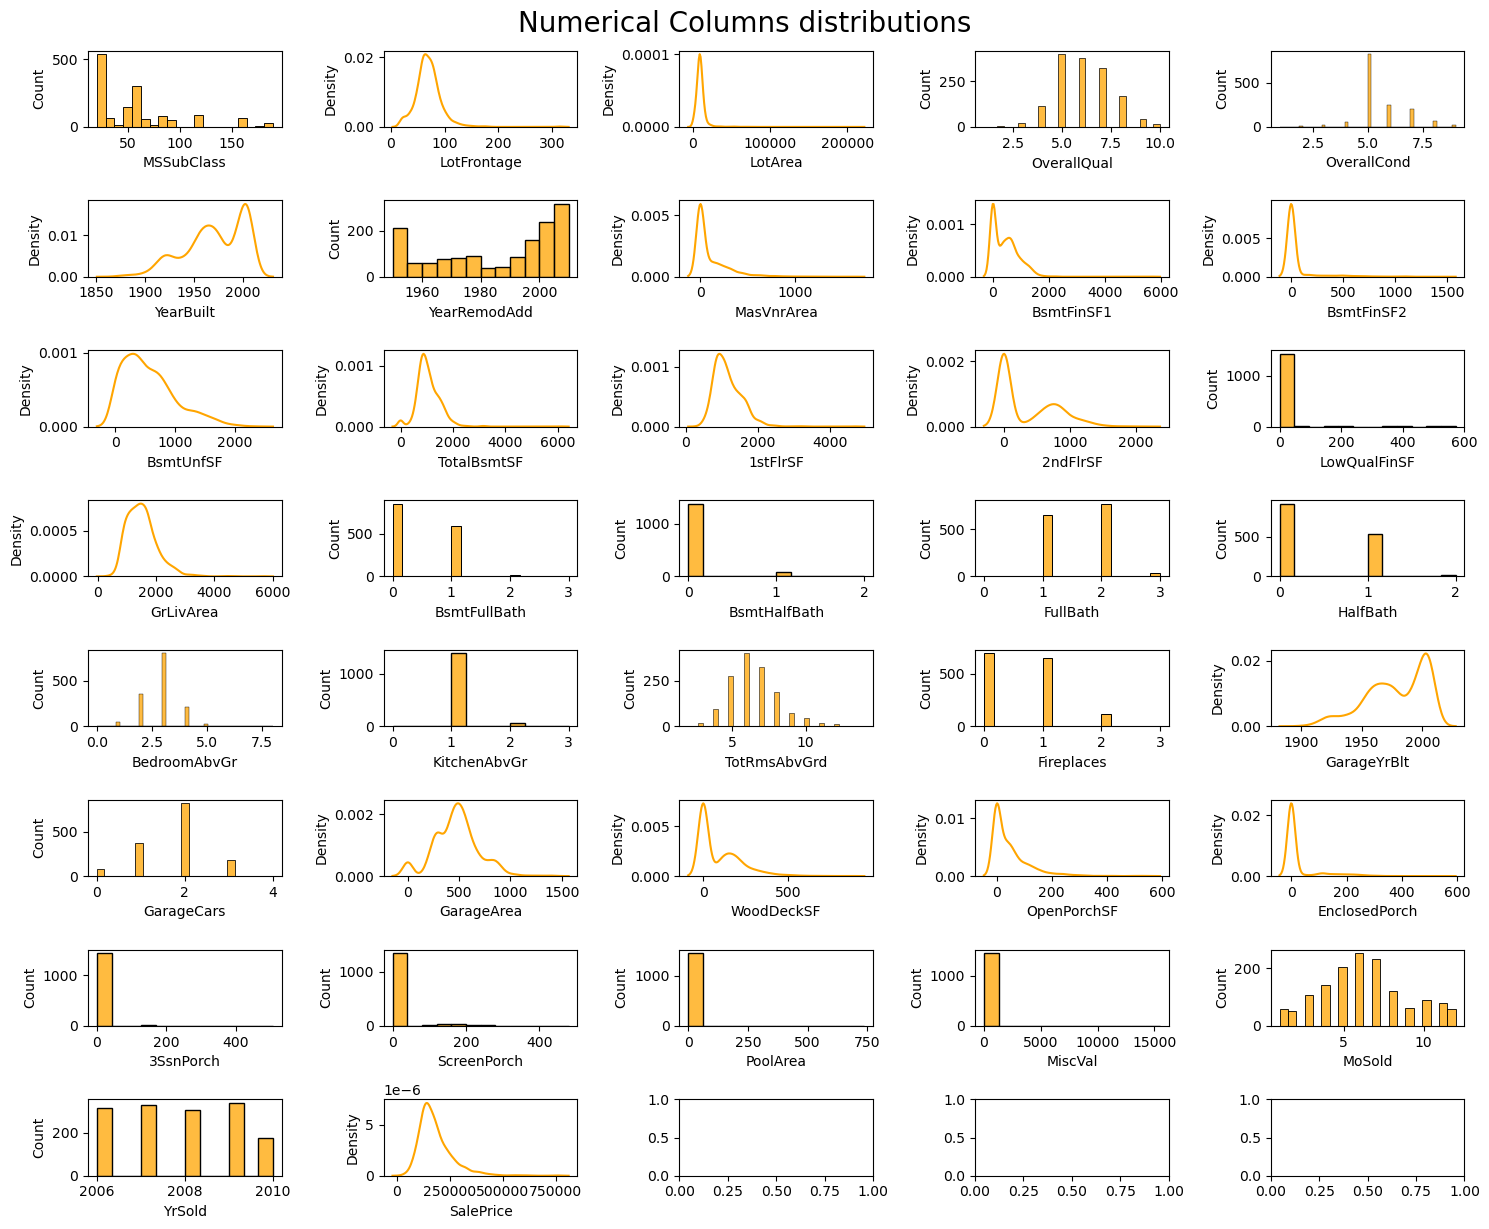

In [13]:
_, axs = plt.subplots(8, 5, figsize=(15, 12))
for col, ax in zip(numerical_columns, axs.ravel()):
    if train[col].dtype == float or (train[col].dtype == int and train[col].nunique() > 100):
        sns.kdeplot(train[col], ax=ax, color='orange')
    else:
        sns.histplot(train[col], ax=ax, color='orange')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Numerical Columns distributions', y=1.02, fontsize=20)
plt.show()

- We can fix some of these distributions with log.
- The double peak distributions should get fixed when we encode the categorical variables.

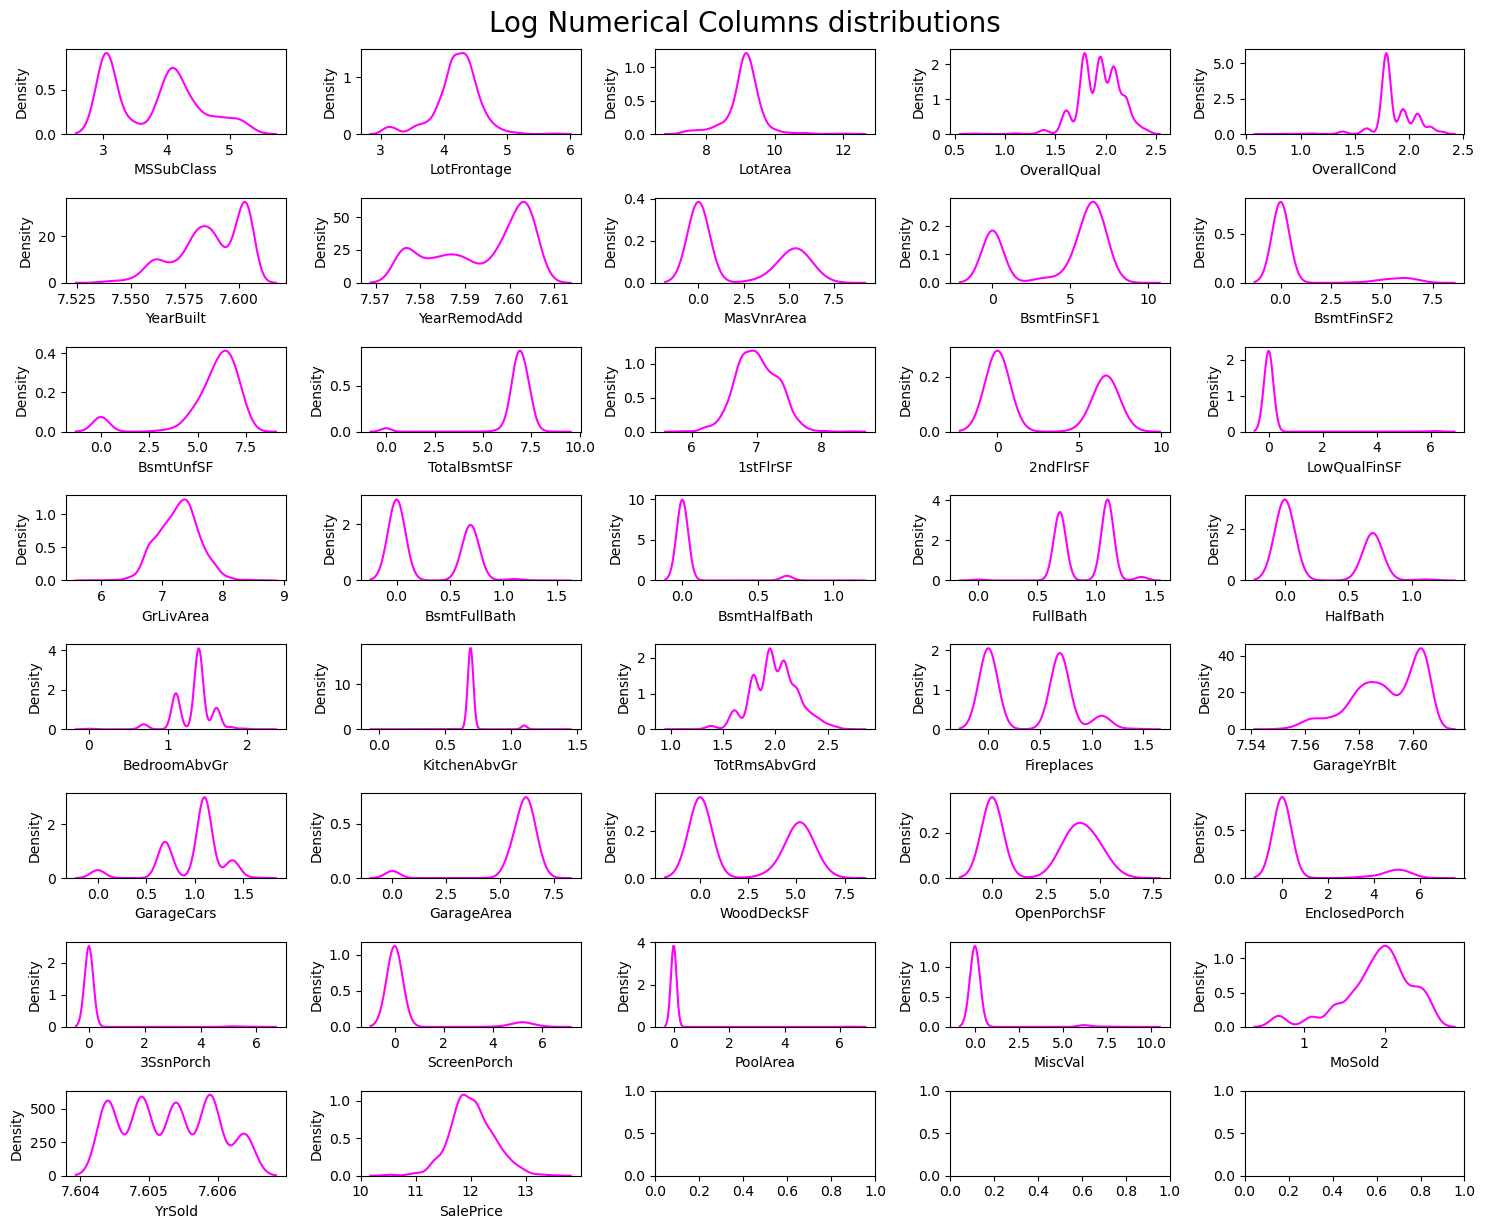

In [14]:
_, axs = plt.subplots(8, 5, figsize=(15, 12))
for col, ax in zip(numerical_columns, axs.ravel()):
    sns.kdeplot(np.log1p(train[col]), ax=ax, color='magenta')
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Log Numerical Columns distributions', y=1.02, fontsize=20)
plt.show()

**Categorical Columns distributions**

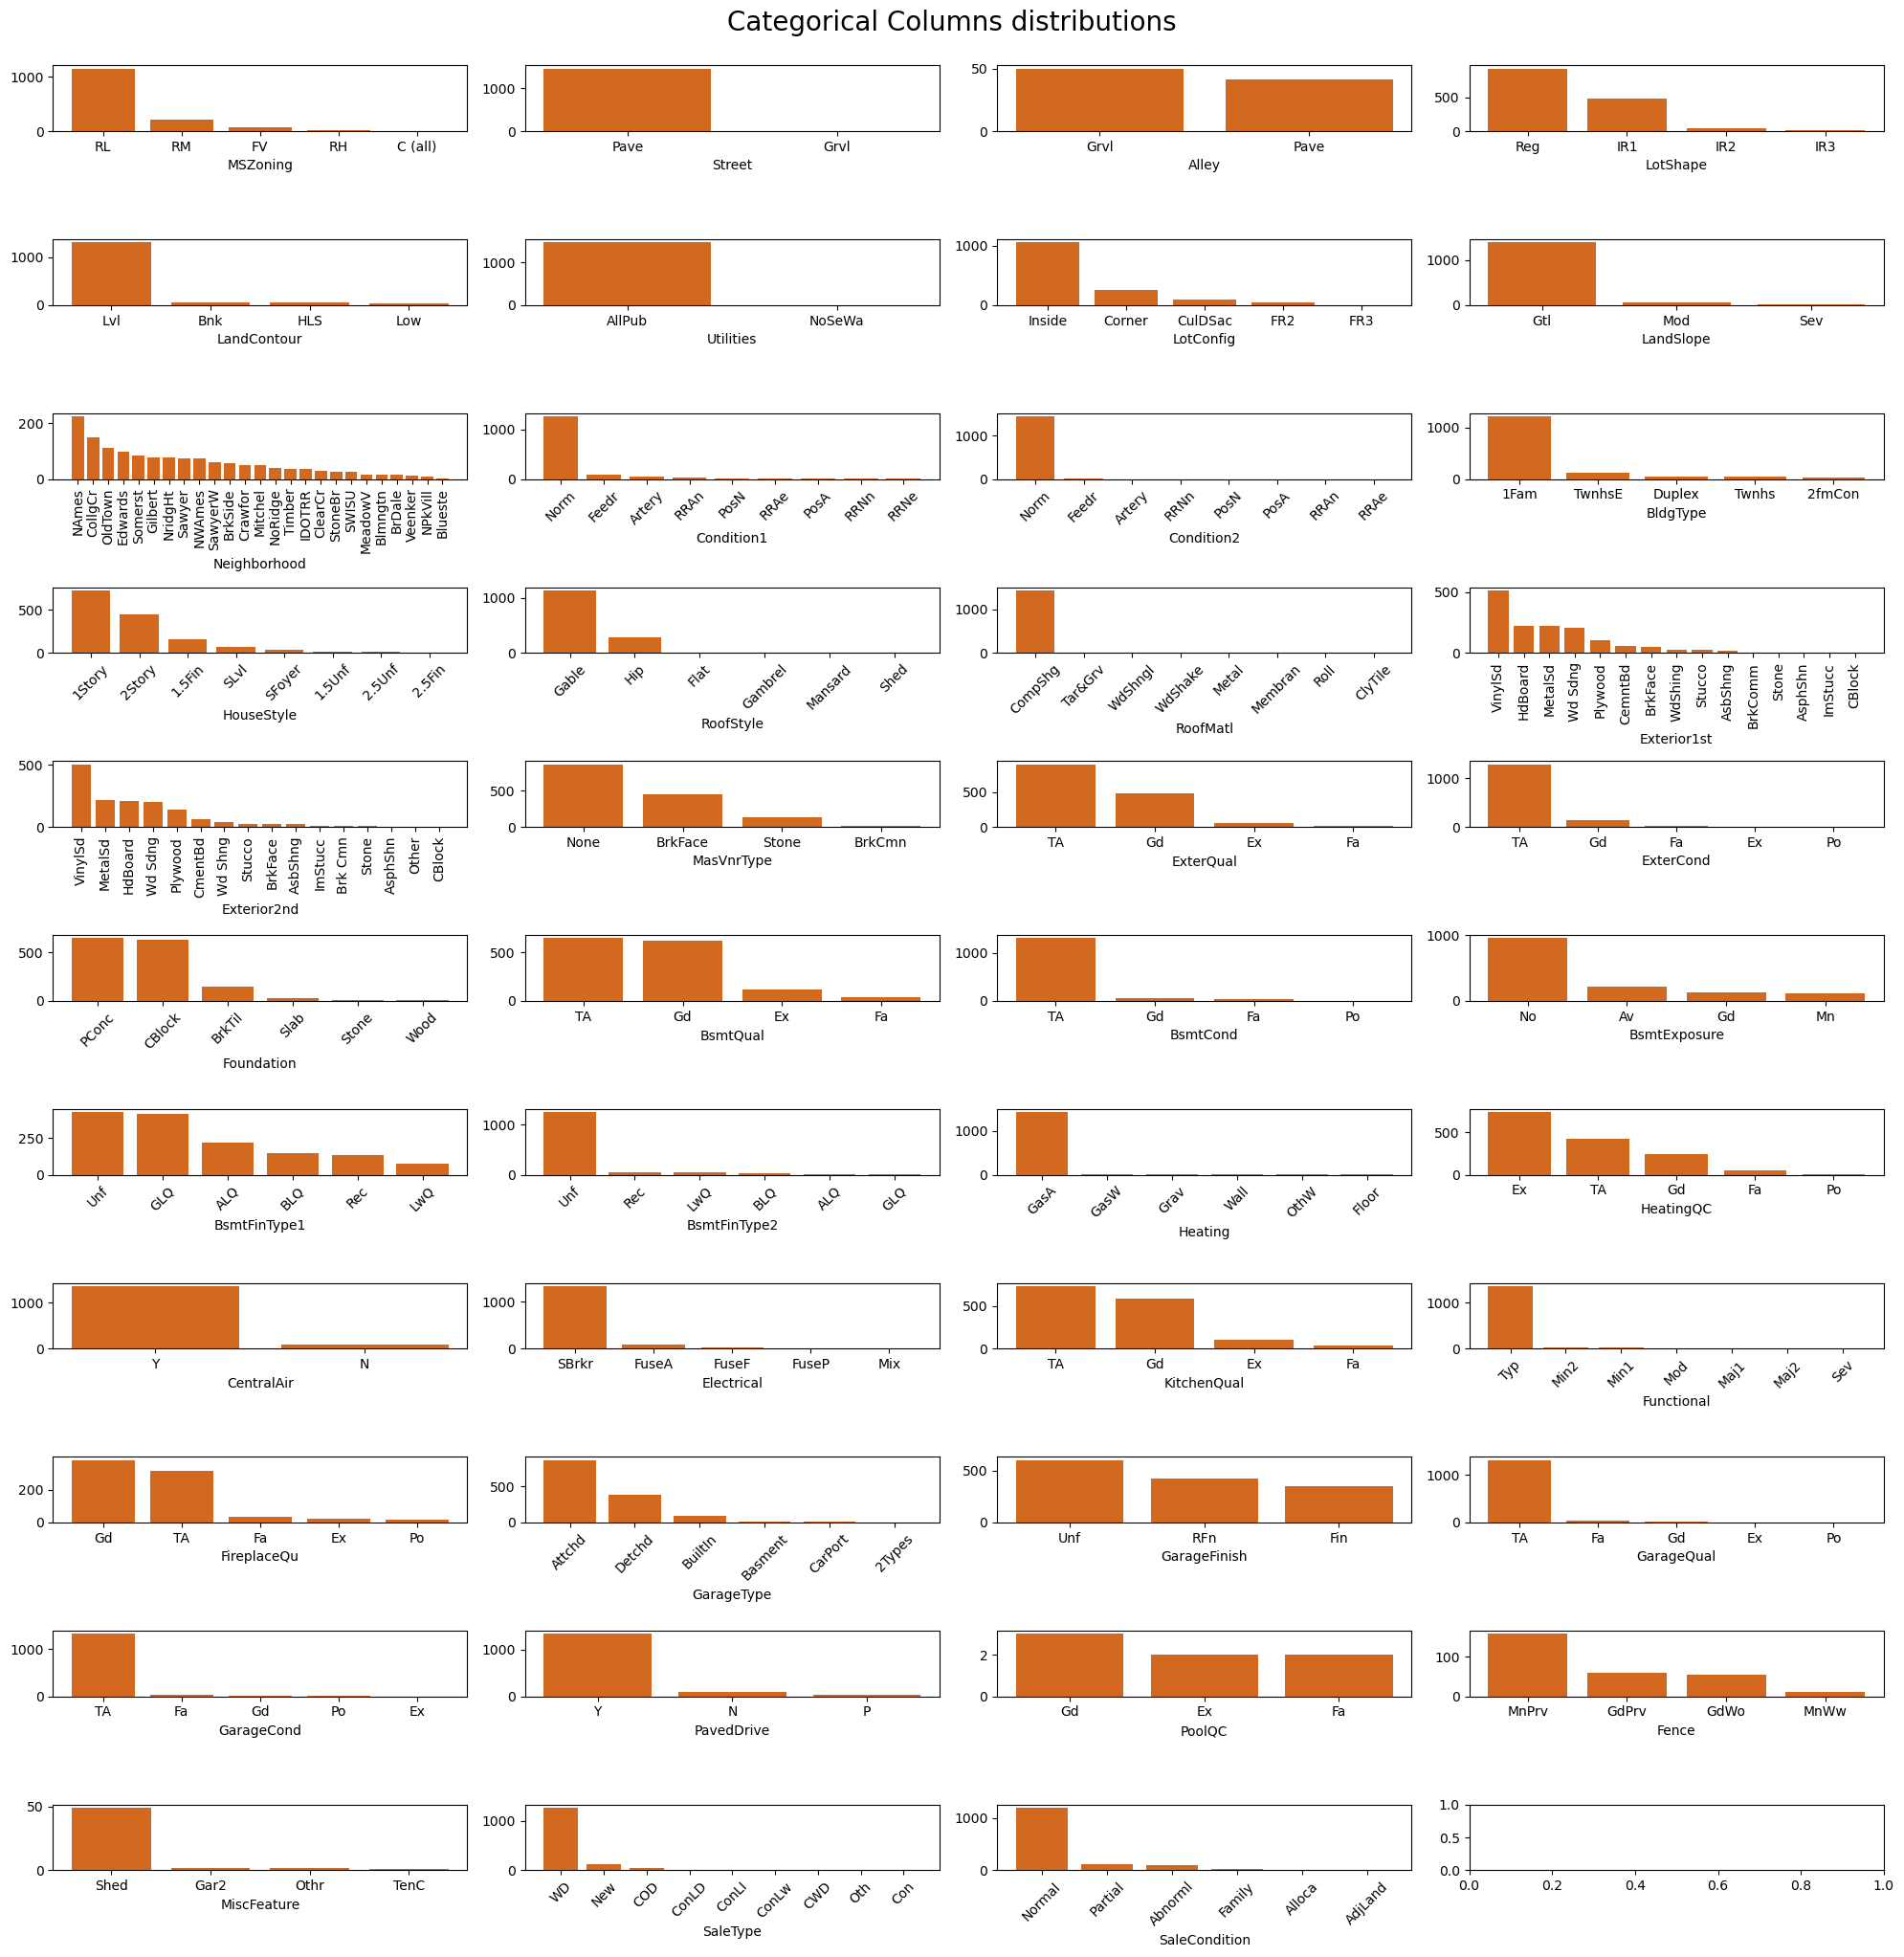

In [15]:
_, axs = plt.subplots(11, 4, figsize=(20, 20))
for col, ax in zip(categorical_columns, axs.ravel()):
    tot_col = 0
    if train[col].dtype == float:
       #ax.hist(train[col], bins=100, color='chocolate')
       print()
    else:
        vc = train[col].value_counts()
        ax.bar(vc.index, vc, color='chocolate')
        tot_col = len(vc.index)

    if tot_col >= 6 and tot_col <= 10:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    elif tot_col > 10:
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel(col)
plt.tight_layout()
plt.suptitle('Categorical Columns distributions', y=1.02, fontsize=20)
plt.show()

**Baseline Score**

In [283]:
def cross_val(model, label, X, y):
    start_time = datetime.now()
    #kf = StratifiedKFold(shuffle=True, random_state=1)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    oof = np.full(len(X), np.nan)
    rmse_list = []
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X, y)):
        X_tr = X.iloc[idx_tr]
        X_va = X.iloc[idx_va]
        y_tr = y.iloc[idx_tr]
        y_va = y.iloc[idx_va]
        model.fit(X_tr, y_tr)
        y_va_pred = model.predict(X_va)
        oof[idx_va] = y_va_pred
        rmse_list.append(np.sqrt(mean_squared_error(y_va, y_va_pred)))
    rmse = np.array(rmse_list).mean()
    execution_time = datetime.now() - start_time
    print(f"# RMSE {rmse:.5f}   time={str(execution_time)[-15:-7]}   {label}")
    result_list.append((int(rmse), label, execution_time))
    return int(rmse)

In [284]:
# Remove columns with null values
categorical_columns = train[categorical_columns].dropna(axis=1).columns
train_num_columns = train[train_num_columns].dropna(axis=1).columns
selected_features = categorical_columns.append(train_num_columns)

categorical_preprocessor = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
log_transformation = FunctionTransformer(np.log1p)
numerical_preprocessor = StandardScaler()   

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('log-transformation', log_transformation, train_num_columns),
    ('standard-scaler', numerical_preprocessor, train_num_columns),
])

X = train[selected_features]

selected_features.shape

(60,)

In [285]:
xgb_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 300,
    'learning_rate': 0.15,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'gamma': 0,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'tree_method': 'gpu_hist',  
    'gpu_id': 0,                
    'predictor': 'gpu_predictor',
    'random_state': 42
}

rmse = cross_val(make_pipeline(preprocessor, XGBRegressor(**xgb_params)), 'Baseline (xgb)', X, y)

# RMSE 25174.75966   time=0:00:05   Baseline (xgb)


In [286]:
params = {
    'boosting_type': 'gbdt',
    'n_estimators': 200,
    'learning_rate': 0.1,
    'num_leaves': 10,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': 42,
    'verbose': -1
}

rmse = cross_val(make_pipeline(preprocessor, lgb.LGBMRegressor(**params)), 'Baseline (lgbm)', X, y)

# RMSE 27314.19120   time=0:00:01   Baseline (lgbm)


By using the data as it is, with some minor standart preprocessing, we get 25k RMSE with XGBoost and 27k RMSE with LGBM

In [287]:
def plotExperiments():
    result_df = pd.DataFrame(result_list, columns=['rmse', 'label', 'time'])
    result_df['time'] = result_df['time'].dt.seconds
    result_df['model'] = result_df['label'].str.split().str[0]
    
    # Sort the DataFrame by RMSE in descending order
    result_df = result_df.sort_values('rmse', ascending=True)
    result_df = result_df.drop_duplicates()

    # Plot
    plt.figure(figsize=(6, len(result_df) * 0.4))

    def color_map(row):
        if row['label'].startswith('Ensemble'):
            return 'green'
        if row['rmse'] < 25000:
            return 'lightgreen'
        return 'yellow'

    colors = result_df.apply(color_map, axis=1)
    bars = plt.barh(range(len(result_df)), result_df['rmse'], color=colors)
    
    # Label the bars with RMSE values
    for bar, rmse in zip(bars, result_df['rmse']):
        plt.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2, f'{rmse}', ha='center', va='center')
    
    plt.yticks(range(len(result_df)), result_df['label'])
    plt.gca().invert_yaxis()
    plt.xticks([0, 10000, 20000, 30000])
    plt.xlabel('RMSE score (lower is better)')
    plt.show()

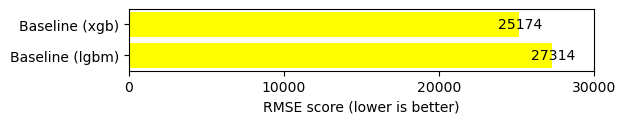

In [288]:
plotExperiments()

## Part 2: Handling Missing data

In [289]:
train[missing_values].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [290]:
# Lets say we want to take into account these extra data
# Let's consider the ones with less than 100 missing points.

incomplete = train.columns[train.isnull().sum() > 0].tolist()
incomplete100 = train.columns[train.isnull().sum() <= 100].tolist()
incomplete_columns = list(set(incomplete) & set(incomplete100))
print(np.sort(incomplete_columns))

['BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'BsmtQual'
 'Electrical' 'GarageCond' 'GarageFinish' 'GarageQual' 'GarageType'
 'GarageYrBlt' 'MasVnrArea' 'MasVnrType']


In [291]:
train[incomplete_columns].head()

,Electrical,MasVnrArea,GarageYrBlt,GarageType,GarageQual,GarageCond,BsmtFinType2,MasVnrType,GarageFinish,BsmtQual,BsmtExposure,BsmtCond,BsmtFinType1
Id,,,,,,,,,,,,,
1,SBrkr,196.0,2003.0,Attchd,TA,TA,Unf,BrkFace,RFn,Gd,No,TA,GLQ
2,SBrkr,0.0,1976.0,Attchd,TA,TA,Unf,None,RFn,Gd,Gd,TA,ALQ
3,SBrkr,162.0,2001.0,Attchd,TA,TA,Unf,BrkFace,RFn,Gd,Mn,TA,GLQ
4,SBrkr,0.0,1998.0,Detchd,TA,TA,Unf,None,Unf,TA,No,Gd,ALQ
5,SBrkr,350.0,2000.0,Attchd,TA,TA,Unf,BrkFace,RFn,Gd,Av,TA,GLQ


- Let's take a look at the descriptions for each one

1. 'BsmtCond': Evaluates the general condition of the basement
2. 'BsmtExposure': Refers to walkout or garden level walls
3. 'BsmtFinType1': Rating of basement finished area
4. 'BsmtFinType2': Rating of basement finished area (if multiple types)
5. 'BsmtQual': Height of the basement
6. 'Electrical': Electrical system
7. 'GarageCond': Garage condition
8. 'GarageFinish': Interior finish of the garage
9. 'GarageQual': Garage quality
10. 'GarageType': Garage location
11. 'GarageYrBlt': Year garage was built
12. 'MasVnrArea': Masonry veneer area in square feet
13. 'MasVnrType': Masonry veneer type
    
 
 - So at first glance, appears obvious that the missing data could be because the house doesn't have a basement or garage. The electrical system seems a bit less obvious one, and might be because of actual missing data because it's just 1 data that has no electrical system. I don't actually know about masonry veneer so I had to ask my friend ChatGPT which said:
 
   Masonry veneer is a type of exterior cladding that provides a **beautiful and durable finish** to a building's façade. There are several types of masonry veneer, including:

    **Brick veneer**: This is the most common type of masonry veneer. It is made up of a layer of bricks that are placed over a frame or wall. The bricks are typically held in place with mortar.

    **Stone veneer**: This type of veneer is made up of thin pieces of natural or manufactured stone that are attached to a frame or wall. Stone veneer can be used to achieve a wide range of aesthetic styles, from rustic to modern.

    **Stucco veneer**: Stucco is a mixture of cement, sand, and water that is applied to a wall or frame to create a smooth or textured finish. Stucco veneer can be colored and textured to mimic the appearance of other types of masonry.

    **Concrete block veneer**: Concrete blocks can be used as a veneer to achieve a modern, industrial look. The blocks can be left unfinished or painted to create a specific aesthetic.

    **Terra cotta veneer**: Terra cotta is a type of clay that can be molded into various shapes and sizes. Terra cotta veneer is a lightweight option that is often used for decorative features, such as window surrounds or cornices.

In [292]:
# Processing: MasVnrType & MasVnrArea
train['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [293]:
train[train['MasVnrType'].isnull()]['MasVnrArea']

Id
235    NaN
530    NaN
651    NaN
937    NaN
974    NaN
978    NaN
1244   NaN
1279   NaN
Name: MasVnrArea, dtype: float64

- In this case we have in MasVnrType a category 'None' which we could use it to default the missing values, and for MasVnrArea we also can see in the data that some have 0.0, which could also work as a default value. We also don't have any more data about the masonry veneer to make us think that there is missing data and instead of 0 or None it could be another category, so best way would be set the values to default.
- Also happens that missing data from 'MasVnrArea' are the same rows, so we can default it to 0.

In [294]:
train['MasVnrType'].dtype, train['MasVnrArea'].dtype, 

(dtype('O'), dtype('float64'))

In [295]:
train.loc[train['MasVnrType'].isnull(), 'MasVnrType'] = 'None'
train.loc[train['MasVnrArea'].isnull(), 'MasVnrArea'] = 0.0
train['MasVnrType'].isnull().sum(), train['MasVnrType'].isnull().sum()

(0, 0)

In [296]:
# Processing: Electrical
train['Electrical'].value_counts(), train['Electrical'].unique()

(SBrkr    1334
 FuseA      94
 FuseF      27
 FuseP       3
 Mix         1
 Name: Electrical, dtype: int64,
 array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object))

In [297]:
# Let's print this 1 row
train[train['Electrical'].isnull()]['SalePrice'].head()
# We can see that it has the Utilities feature set to 'AllPub': All public Utilities (E,G,W,& S).
# I wouldn't mess much with only 1 datapoint
# so I'll set it to the average Electrical System: SBrkr Standard Circuit Breakers & Romex

Id
1380    167500
Name: SalePrice, dtype: int64

In [298]:
train['Electrical'].dtype

dtype('O')

In [299]:
# Fill Electrical
train.loc[train['Electrical'].isnull(), 'Electrical'] = 'SBrkr'
train['Electrical'].isnull().sum()

0

In [300]:
# Processing: Basement
bsmt_columns = ['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual']
train[bsmt_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   BsmtCond      1423 non-null   object
 1   BsmtExposure  1422 non-null   object
 2   BsmtFinType1  1423 non-null   object
 3   BsmtFinType2  1422 non-null   object
 4   BsmtQual      1423 non-null   object
dtypes: object(5)
memory usage: 68.4+ KB


In [301]:
train[bsmt_columns].isnull().sum()

BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
BsmtQual        37
dtype: int64

Check the features with 38 values

In [302]:
train[bsmt_columns][train['BsmtExposure'].isnull()]

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
Id,,,,,
18,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN
91,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN
157,NaN,NaN,NaN,NaN,NaN
183,NaN,NaN,NaN,NaN,NaN
260,NaN,NaN,NaN,NaN,NaN
343,NaN,NaN,NaN,NaN,NaN
363,NaN,NaN,NaN,NaN,NaN


In [303]:
train[bsmt_columns][train['BsmtFinType2'].isnull()]

,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual
Id,,,,,
18,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN
91,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN
157,NaN,NaN,NaN,NaN,NaN
183,NaN,NaN,NaN,NaN,NaN
260,NaN,NaN,NaN,NaN,NaN
333,TA,No,GLQ,NaN,Gd
343,NaN,NaN,NaN,NaN,NaN


- If we take a look, we can see that almost all the missing data from the basement comes from the same houses.
- We could just assume that those houses don't have a basement, but we have to look just in case there is some inconsistent data, for example, another feature that has a label which indicates the pressence of a basement.
- What other features consider a basement? and how it tells us if there is no basement?


- If we take a look at the data description we have that we have for example:

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
      
        
- But both are valid since they meet the relation, because has TA as Basement condition, we know it has a basement but BsmtExposure is NaN, which could mean that it has no exposue of the basement, because the other data gives me indications that it has a basement.
- And in the case of BsmtFinType2 is the same, we can complete it with Unf. or NA.
     

- So now we can complete this data and fill those values with the NA category

In [304]:
for i in bsmt_columns:
    train.loc[train[i].isnull(), i] = 'NA'

In [305]:
train[bsmt_columns].isnull().sum()

BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtQual        0
dtype: int64

- Let's check again the missing data

In [306]:
train[missing_values].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         0
MasVnrArea         0
BsmtQual           0
BsmtCond           0
BsmtExposure       0
BsmtFinType1       0
BsmtFinType2       0
Electrical         0
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [307]:
garage_columns = ["GarageType", "GarageYrBlt", "GarageFinish", "GarageQual", "GarageCond"]

In [308]:
train[garage_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   GarageType    1379 non-null   object 
 1   GarageYrBlt   1379 non-null   float64
 2   GarageFinish  1379 non-null   object 
 3   GarageQual    1379 non-null   object 
 4   GarageCond    1379 non-null   object 
dtypes: float64(1), object(4)
memory usage: 68.4+ KB


In [309]:
# Let's check how many data has missing for every garage column
for i in garage_columns:
    print(len(train[i][train[i].isnull()]))

81
81
81
81
81


In [310]:
# Are they all the same?
indexes = []
for i in garage_columns:
    indexes.append(list(train[i][train[i].isnull()].index))
are_equal = True
for i in range(len(indexes) - 1):
    for j in range(i + 1, len(indexes)):
        if indexes[i] != indexes[j]:
            are_equal = False
            break
if are_equal:
    print("Equal")
else:
    print("Different")

Equal


- Here we encounter one problem. We could fill almost all these categories with NA for no garage, but because there is no garage, we can't fill the column GarageYrBlt with 0. So we'll treat this one differently.

GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
GarageYrBlt: Year garage was built
		
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

In [311]:
garage_columns = ["GarageType", "GarageFinish", "GarageQual", "GarageCond"] # Removed year built garage

In [312]:
# Filling the columns with data
for i in garage_columns:
    train.loc[train[i].isnull(), i] = 'NA'

In [313]:
# Check again
for i in garage_columns:
    print(len(train[i][train[i].isnull()]))

0
0
0
0


In [314]:
# Imputing GarageYrBlt
# Let's check what looks like in detail
train['GarageYrBlt'].sort_values().tail()

Id
1350   NaN
1408   NaN
1450   NaN
1451   NaN
1454   NaN
Name: GarageYrBlt, dtype: float64

In [315]:
train['GarageYrBlt'][train['GarageYrBlt'].isnull()==True].shape[0]

81

In [316]:
train.loc[train['GarageYrBlt'][train['GarageYrBlt'].isnull()==True].index,train.columns[train.columns.str.contains('Yr')]].head()

,GarageYrBlt,YrSold
Id,,
40,NaN,2008
49,NaN,2009
79,NaN,2010
89,NaN,2009
90,NaN,2007


In [317]:
train.loc[train['GarageYrBlt'].isnull()==True, train.columns.str.contains('Garage')].sample(10)

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
Id,,,,,,,
156,NA,NaN,NA,0,0,NA,NA
529,NA,NaN,NA,0,0,NA,NA
308,NA,NaN,NA,0,0,NA,NA
1284,NA,NaN,NA,0,0,NA,NA
211,NA,NaN,NA,0,0,NA,NA
1326,NA,NaN,NA,0,0,NA,NA
141,NA,NaN,NA,0,0,NA,NA
1180,NA,NaN,NA,0,0,NA,NA
49,NA,NaN,NA,0,0,NA,NA


- This certainly looks like there is no garage in these houses, so let's fill the value with 0.

In [318]:
train.loc[train['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 0.0

In [319]:
# No missing garage data
train.loc[:, train.columns.str.contains('Garage')].isnull().sum().sum()

0

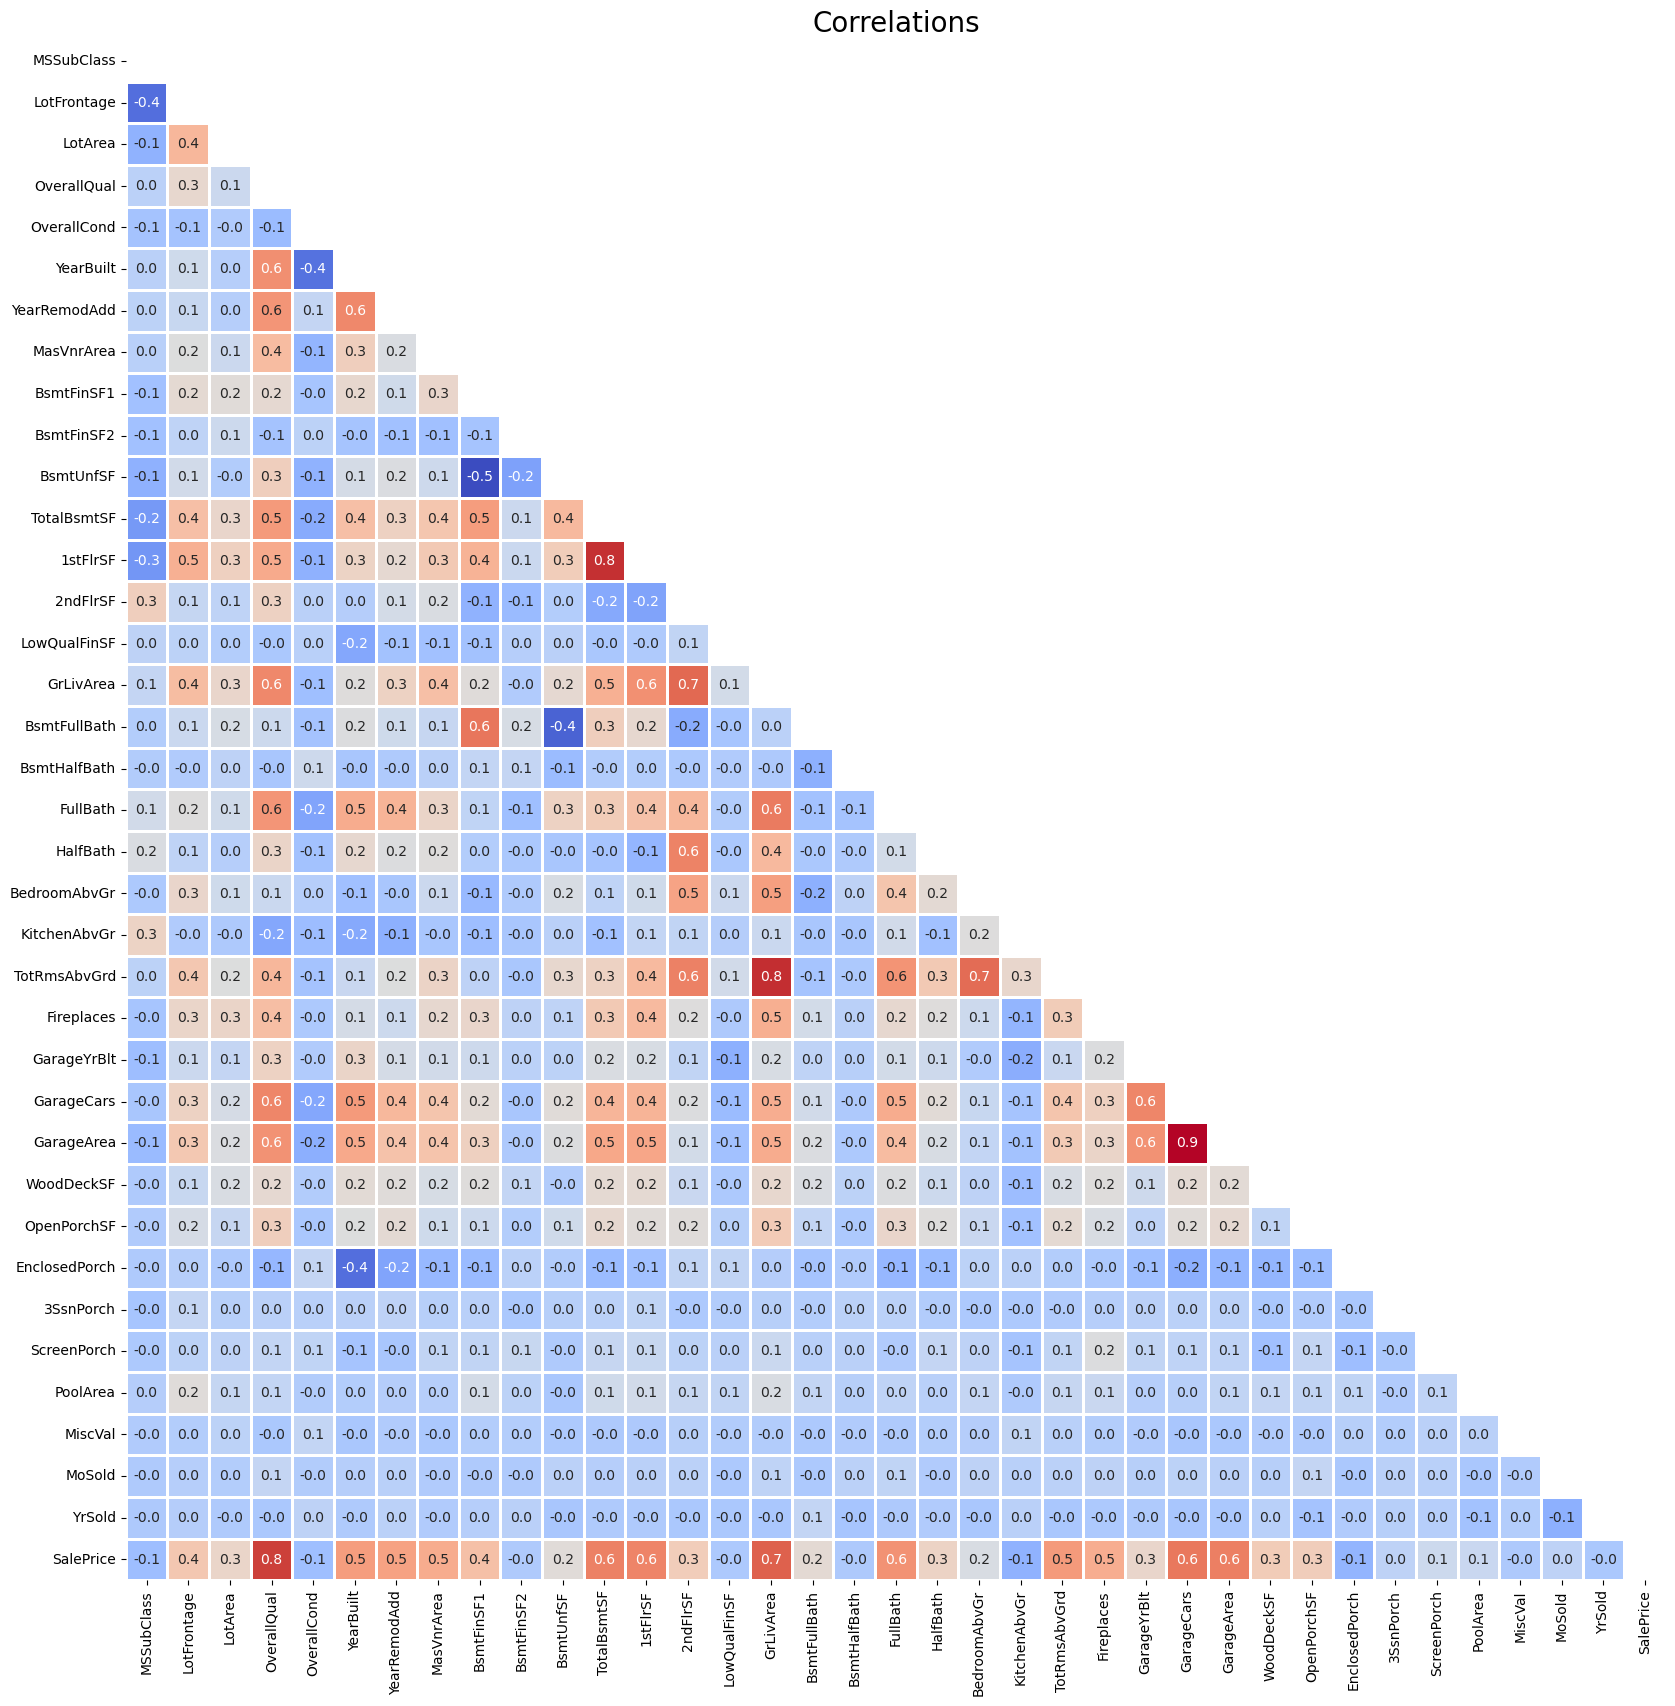

In [320]:
a = train[numerical_columns].copy()
a = a.corr()
mask = np.triu(a.corr())

plt.figure(figsize=(20, 20))

sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)

plt.title("Correlations",fontsize = 20)
plt.show()


OverallQual

In [321]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_plot = pd.DataFrame(scaler.fit_transform(train[['OverallQual', 'SalePrice']]), columns=['OverallQual', 'SalePrice'])
px.scatter(df_plot, x='OverallQual', y='SalePrice', color='SalePrice')

GrLivArea

In [322]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_plot = pd.DataFrame(scaler.fit_transform(train[['GrLivArea', 'SalePrice']]), columns=['GrLivArea', 'SalePrice'])
px.scatter(df_plot, x='GrLivArea', y='SalePrice', color='SalePrice')

## Part 3: Testing our new features

- It seems using the year 0 will affect the distribution of the data, so I guess it's better to leave it Null.

In [323]:
numerical_columns = train.select_dtypes(include=['int', 'float']).columns
categorical_columns = train.select_dtypes(include=['object']).columns
train_num_columns = numerical_columns.drop('SalePrice')

categorical_columns = train[categorical_columns].dropna(axis=1).columns
train_num_columns = train[train_num_columns].dropna(axis=1).columns

selected_features = categorical_columns.append(train_num_columns)

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('log-transformation', log_transformation, train_num_columns),
    ('standard-scaler', numerical_preprocessor, train_num_columns),
])

X = train[selected_features]

train_num_columns.shape, categorical_columns.shape, X.shape

((35,), (38,), (1460, 73))

In [324]:
preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor,  categorical_columns),
    ('log-transformation', log_transformation, train_num_columns),
    ('standard-scaler', numerical_preprocessor, train_num_columns),
])

X = train[selected_features]
y = train['SalePrice']

In [325]:
rmse = cross_val(make_pipeline(preprocessor, XGBRegressor(**xgb_params)), 'FS-xgb', X, y)

# RMSE 25359.17894   time=0:00:04   FS-xgb


In [326]:
rmse = cross_val(make_pipeline(preprocessor, lgb.LGBMRegressor(**params)), 'Features-lgbm', X, y)

# RMSE 27229.01081   time=0:00:01   Features-lgbm


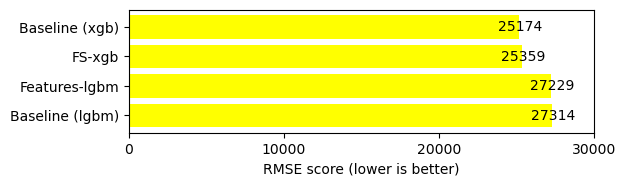

In [327]:
plotExperiments()

In [328]:
gc.collect()

270123

- We haven't got much of an improvement over the baseline method, so we might want to take out features.

## Part 4: Feature Selection

- Filter variables with a variance threshold. This will take out features what has (1-threshold)% the same numerical values.

In [329]:
categorical_columns.shape, train_num_columns.shape

((38,), (35,))

In [330]:
variance_threshold_preprocessor = VarianceThreshold(threshold=0.1)

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('log-transformation', log_transformation, train_num_columns),
    ('standard-scaler', numerical_preprocessor, train_num_columns),
    ('variance-threshold', variance_threshold_preprocessor, train_num_columns),
])

X = train[selected_features]
y = train['SalePrice']

rmse = cross_val(make_pipeline(preprocessor, XGBRegressor(**xgb_params)), 'Var-xgb', X, y)

# RMSE 25359.17894   time=0:00:04   Var-xgb


In [331]:
rmse = cross_val(make_pipeline(preprocessor, lgb.LGBMRegressor(**params)), 'LGBMRegressor', X, y)

# RMSE 27229.01081   time=0:00:01   LGBMRegressor


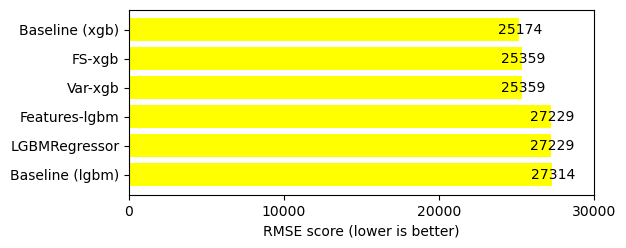

In [332]:
plotExperiments()

In [333]:
gc.collect()

3583

- Following what recommends the official page of Sequential Feature Selection https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py
- We use RidgeCV which is a Ridge regression model that includes cross validation (CV) for selecting the most important feature.
- Regression feature selection works by fitting a model and extracting the betas/coefficients of each feature.


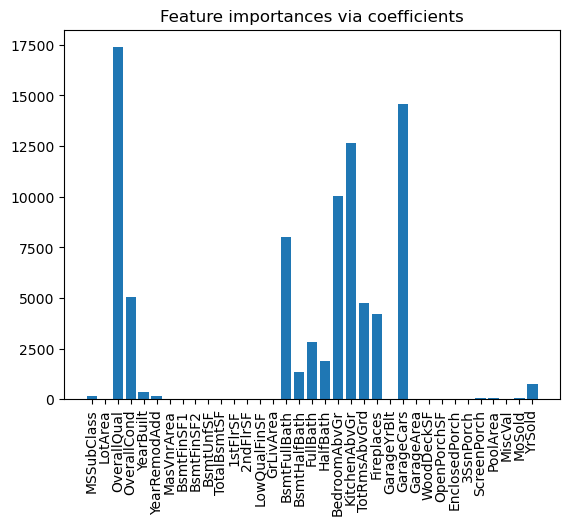

In [334]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV().fit(train[train_num_columns], y)
importance = np.abs(ridge.coef_)
plt.bar(height=importance, x=train[train_num_columns].columns)
plt.title("Feature importances via coefficients")
plt.xticks(rotation=90)
plt.show()

- Which gives us the following top 5 features

In [335]:
importance_df = pd.DataFrame({'Feature': train[train_num_columns].columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_n = 10
best_features = importance_df[:top_n]

# Display or use the best features
print("Top {} features:".format(top_n))
print(best_features.reset_index(drop=True))
best_features=best_features['Feature']

Top 10 features:
        Feature    Importance
0   OverallQual  17382.606050
1    GarageCars  14595.882763
2  KitchenAbvGr  12650.207887
3  BedroomAbvGr  10008.881597
4  BsmtFullBath   7986.567926
5   OverallCond   5044.332658
6  TotRmsAbvGrd   4738.294709
7    Fireplaces   4200.596694
8      FullBath   2836.963316
9      HalfBath   1905.248254


In [336]:
selected_features = categorical_columns.append(train[best_features.values].columns)
best_num_feat = train[best_features.values].columns

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('log-transformation', log_transformation, best_num_feat),
    ('standard-scaler', numerical_preprocessor, best_num_feat)
])

X = train[selected_features]
y = train['SalePrice']

rmse = cross_val(make_pipeline(preprocessor, XGBRegressor(**xgb_params)), 'Top10-Num xgb', X, y)

# RMSE 28886.23425   time=0:00:03   Top10-Num xgb


In [337]:
rmse = cross_val(make_pipeline(preprocessor, lgb.LGBMRegressor(**params)), 'Top10-Num ', X, y)

# RMSE 30413.79323   time=0:00:00   Top10-Num 


In [338]:
gc.collect()

8547

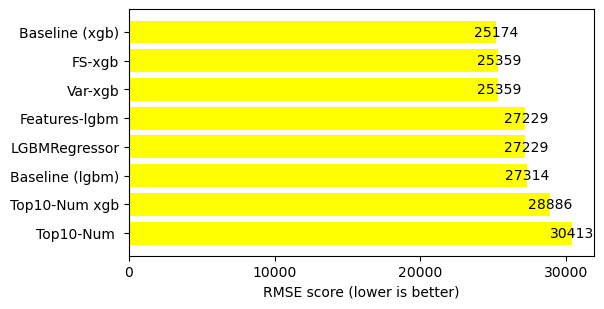

In [339]:
plotExperiments()

### Analysis
- The performance went down after removing more than half features in order to include the top 10 numerical columns.
- As we saw in the correlation plot, there aren't much high correlated features, thus, removing many numerical features causes drop in performance.
- Also, we haven't yet worked with the categorical features which are much higher in number.

**Sequential Feature Selection**


In [340]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_data = encoder.fit_transform(train[categorical_columns])
encoded_columns = encoder.get_feature_names_out()
df_encoded = pd.DataFrame(encoded_data, columns=encoded_columns, index=train.index) #Preserve the same index
df_encoded.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [341]:
df_merged = pd.concat([train[numerical_columns], df_encoded], axis=1)
df_merged = df_merged.dropna(axis=1)
df_merged.drop(columns='SalePrice', inplace=True)
df_merged.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,8450,7,5,2003,2003,196.0,706,0,150,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,20,9600,6,8,1976,1976,0.0,978,0,284,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60,11250,7,5,2001,2002,162.0,486,0,434,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,70,9550,7,5,1915,1970,0.0,216,0,540,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
5,60,14260,8,5,2000,2000,350.0,655,0,490,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [342]:
from sklearn.feature_selection import SelectFromModel

# Selects the threshold of the third best feature importance
threshold = np.sort(importance)[-3] + 0.01

tic = time.time()
sfm = SelectFromModel(ridge, threshold=threshold).fit(df_merged, y)
toc = time.time()

print(f"Features selected by SelectFromModel: {df_merged.columns[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: Index(['Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Mitchel',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_StoneBr',
       'Condition2_PosN', 'RoofMatl_ClyTile', 'RoofMatl_WdShngl',
       'BsmtQual_Ex', 'BsmtExposure_Gd', 'KitchenQual_Ex'],
      dtype='object')
Done in 0.405s


- And now finally we use the SequentialFeatureSelector
- We can do a forward selection where we start with the 2 features and then we add 1 feature and see if the new subset improves or not, with backwards is the opposite

In [343]:
from sklearn.feature_selection import SequentialFeatureSelector

tic_fwd = time.time()
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=60, direction="forward"
).fit(df_merged, y)
toc_fwd = time.time()

In [344]:
print(
    "Features selected by forward sequential selection: "
    f"{df_merged.columns[sfs_forward.get_support()]}"
)
print(f"Done in {toc_fwd - tic_fwd:.3f}s")

Features selected by forward sequential selection: Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'MasVnrArea', 'BsmtFinSF1', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'WoodDeckSF', 'ScreenPorch',
       'MSZoning_C (all)', 'LotShape_IR2', 'LandContour_Bnk',
       'Utilities_AllPub', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Condition1_Norm', 'Condition1_RRAe', 'BldgType_2fmCon',
       'RoofMatl_ClyTile', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace',
       'MasVnrType_BrkCmn', 'ExterCond_Ex', 'BsmtQual_Ex', 'BsmtCond_TA',
       'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn',
      

In [345]:
"""tic_bwd = time.time()
sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=5, direction="backward"
).fit(df_merged, y)
toc_bwd = time.time()

print(
    "Features selected by backward sequential selection: "
    f"{df_merged.columns[sfs_backward.get_support()]}"
)
print(f"Done in {toc_bwd - tic_bwd:.3f}s")"""

'tic_bwd = time.time()\nsfs_backward = SequentialFeatureSelector(\n    ridge, n_features_to_select=5, direction="backward"\n).fit(df_merged, y)\ntoc_bwd = time.time()\n\nprint(\n    "Features selected by backward sequential selection: "\n    f"{df_merged.columns[sfs_backward.get_support()]}"\n)\nprint(f"Done in {toc_bwd - tic_bwd:.3f}s")'

In [346]:
new_columns = df_merged.columns[sfs_forward.get_support()]
forward_num_feat = numerical_columns[numerical_columns.isin(new_columns)]
forward_cat_feat = df_merged.columns[(~df_merged.columns.isin(forward_num_feat)) & (df_merged.columns.isin(new_columns))]

variance_threshold_preprocessor = VarianceThreshold(threshold=0.1)

preprocessor = ColumnTransformer([
    #('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('log-transformation', log_transformation, forward_num_feat),
    ('standard-scaler', numerical_preprocessor, forward_num_feat),
    ('variance-threshold', variance_threshold_preprocessor, new_columns),
])

X = df_merged[new_columns]

rmse = cross_val(make_pipeline(preprocessor, XGBRegressor(**xgb_params)), 'Top20 Forward xgb', X, y)

# RMSE 28618.35480   time=0:00:03   Top20 Forward xgb


In [347]:
rmse = cross_val(make_pipeline(preprocessor, lgb.LGBMRegressor(**params)), 'Top20 Forward lgbm', X, y)

# RMSE 28011.60034   time=0:00:00   Top20 Forward lgbm


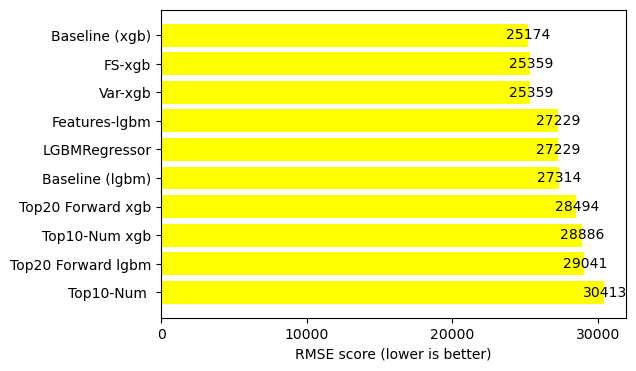

In [268]:
plotExperiments()

### Evaluation
- As far as I experimented, I couldn't find a reliable subset of features that improve performance, thus we should add more features.
- For this reason Backward feature selection isn't a reliable solution, because it's very costly.
- Instead we could add more features instead of choosing an strategy for removing features (beyond what the VarianceThreshold was able to do).

- I've been plotting many times different features against others, using more feature selection techniques without achieving significant results.
- 

****